In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

#Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

In [10]:
df = pd.read_csv('nyc_data.csv', index_col = 'Date', parse_dates=True)
df = df.asfreq('D')
df.rename(columns={'Demand': 'y'}, inplace=True)
df

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...
2020-12-27,685.915026,0,0,0,2.89,38.674
2020-12-28,998.051170,0,0,0,8.83,166.712
2020-12-29,847.123399,0,0,0,3.48,161.865


Exploratory Data Analysis

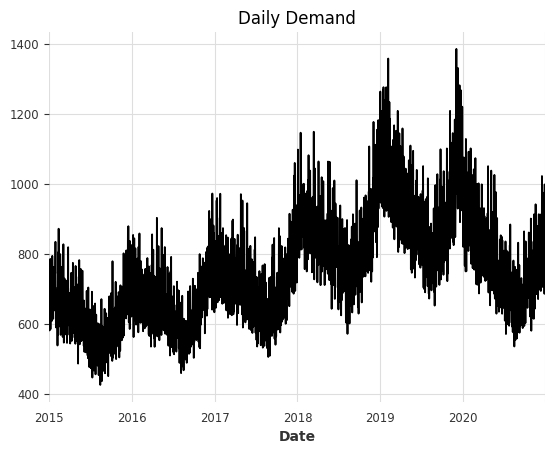

In [15]:
df['y'].plot()
plt.title('Daily Demand');

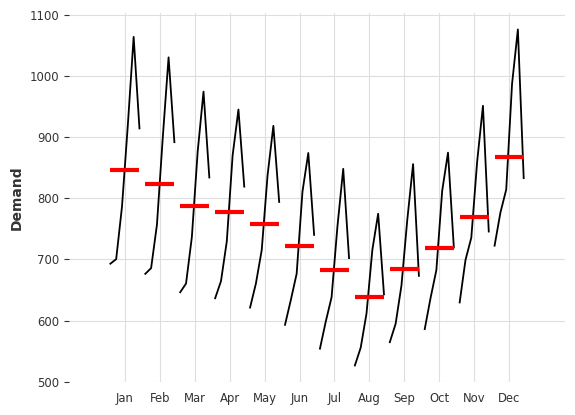

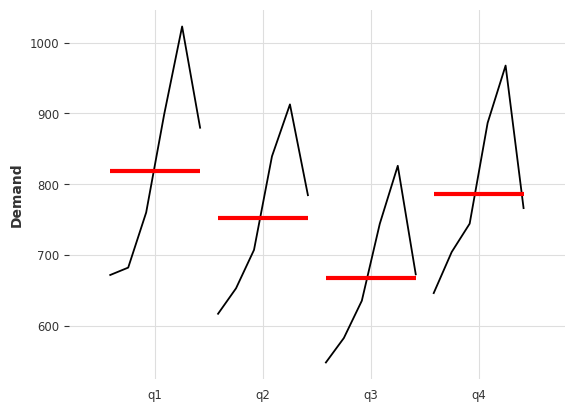

In [24]:
month_plot(df['y'].resample('ME').mean(), ylabel='Demand')
quarter_plot(df['y'].resample('QE').mean(), ylabel='Demand');

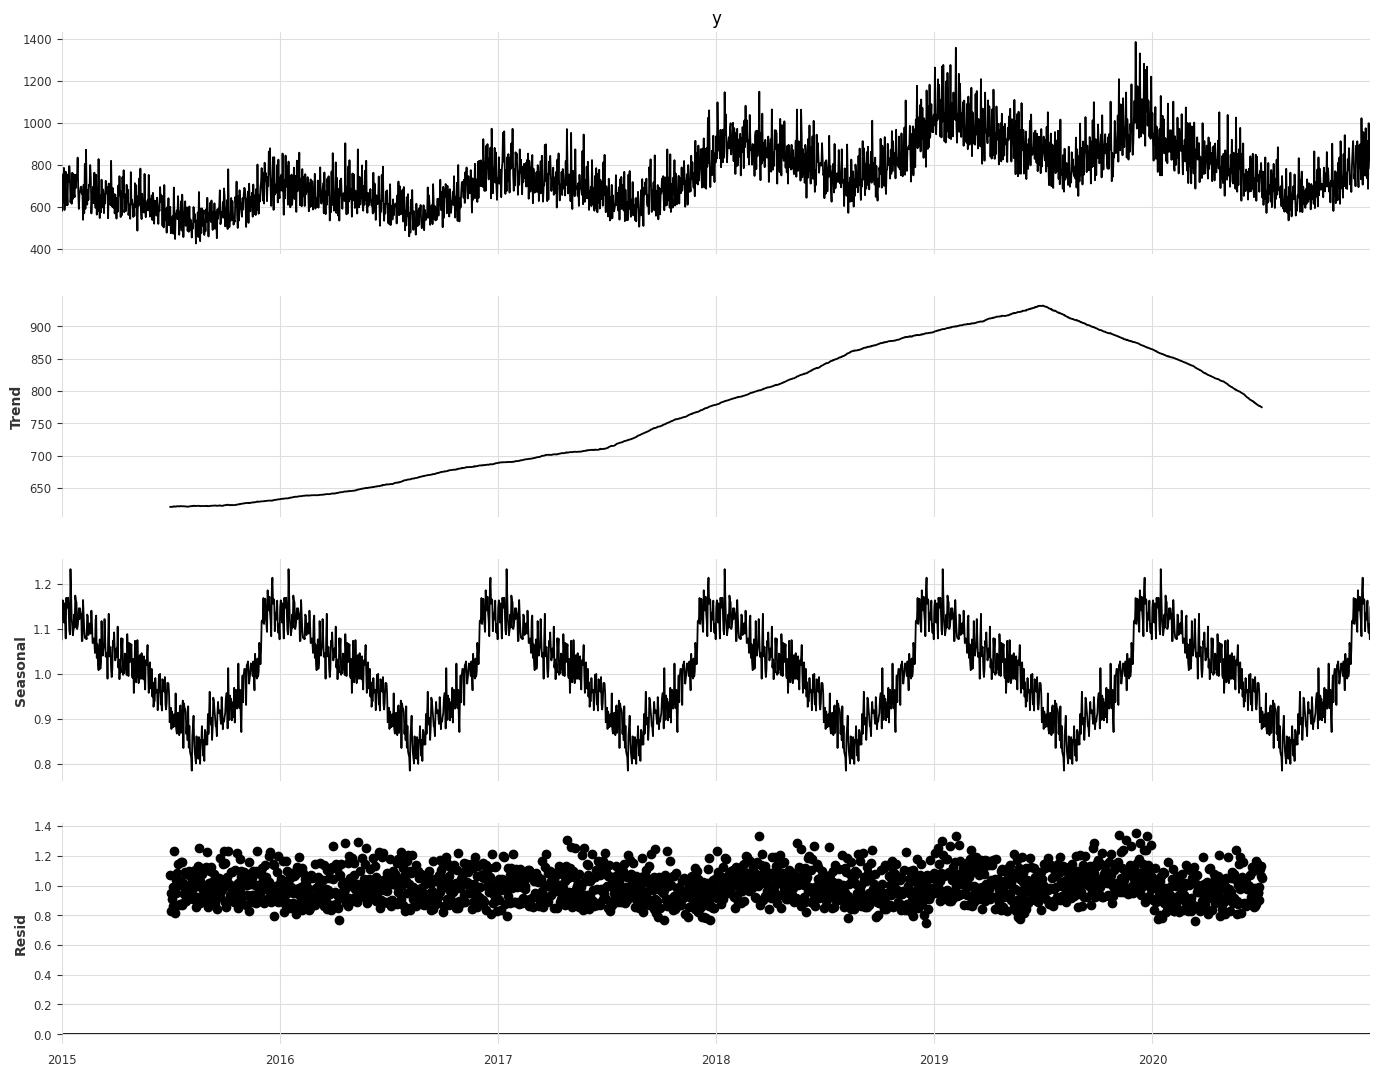

In [29]:
fig = seasonal_decompose(df['y'], model='mul', period=365).plot()
fig.set_size_inches(15,12)
plt.show()

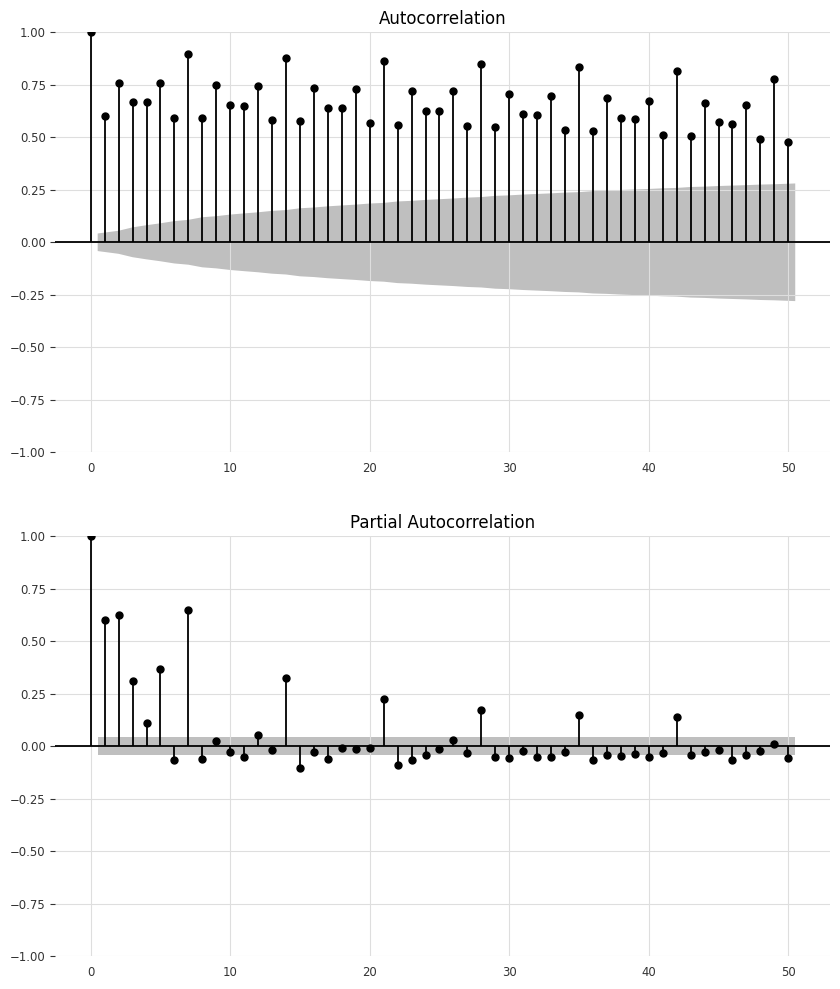

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
plot_acf(df['y'], lags=50, ax=ax[0])
plot_pacf(df['y'], lags=50, ax=ax[1])
plt.show()

Prepare the Model

In [42]:
series = TimeSeries.from_series(df['y'])
covariates = TimeSeries.from_dataframe(df.iloc[:,1:])

In [ ]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0]),
                attribute = 'year',
                one_hot=False)

month_series = datetime_attribute_timeseries(year_series,
                                             attribute='month',
                                             one_hot=True)

weekday_series = datetime_attribute_timeseries(year_series,
                                               attribute='weekday',
                                               one_hot=True)

In [50]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

covariates = covariates.stack(year_series)

covariates_transformed = scaler_covariates.fit_transform(covariates)
covariates_transformed = covariates_transformed.stack(month_series).stack(weekday_series)

In [54]:
forecast_horizon = 31
input_chunk_length = 46

training_length = forecast_horizon + input_chunk_length

In [56]:
model = RNNModel(model = 'LSTM',
                 hidden_dim=20,
                 n_rnn_layers=2,
                 dropout=0.1,
                 n_epochs=10,
                 optimizer_kwargs={'lr': 0.003},
                 random_state=42,
                 training_length=training_length,
                 input_chunk_length=input_chunk_length,
                 pl_trainer_kwargs= {'accelerator': 'cpu'})

model.fit(y_transformed, future_covariates=covariates_transformed)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 67/67 [00:03<00:00, 20.20it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:03<00:00, 20.19it/s, train_loss=0.00303]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=77, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=42, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'cpu'})

Cross Validation

In [57]:
cv = model.historical_forecasts(series = y_transformed,
                                future_covariates = covariates_transformed,
                                start = df.shape[0] - 180,
                                forecast_horizon = forecast_horizon,
                                stride = 16,
                                retrain=True,
                                last_points_only=False)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
---------------------------------------------

Epoch 9: 100%|██████████| 61/61 [00:02<00:00, 21.54it/s, train_loss=0.00304]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:02<00:00, 21.52it/s, train_loss=0.00304]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 61/61 [00:02<00:00, 20.64it/s, train_loss=0.0028] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:02<00:00, 20.62it/s, train_loss=0.0028]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 62/62 [00:02<00:00, 20.73it/s, train_loss=0.00331]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:02<00:00, 20.71it/s, train_loss=0.00331]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 62/62 [00:02<00:00, 22.35it/s, train_loss=0.00311]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:02<00:00, 22.33it/s, train_loss=0.00311]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 63/63 [00:02<00:00, 22.54it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:02<00:00, 22.52it/s, train_loss=0.00276]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 63/63 [00:02<00:00, 22.95it/s, train_loss=0.00294]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:02<00:00, 22.93it/s, train_loss=0.00294]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 64/64 [00:02<00:00, 22.30it/s, train_loss=0.00284]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:02<00:00, 22.28it/s, train_loss=0.00284]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 64/64 [00:03<00:00, 20.96it/s, train_loss=0.00273]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:03<00:00, 20.94it/s, train_loss=0.00273]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 65/65 [00:03<00:00, 20.24it/s, train_loss=0.00316]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:03<00:00, 20.22it/s, train_loss=0.00316]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 21.87it/s, train_loss=0.00307]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:02<00:00, 21.85it/s, train_loss=0.00307]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [58]:
rmse_cv = []

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()

    actuals = df['y'][start:end,]

    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

print(np.mean(rmse_cv))

98.98334890977227
